# Exoplanet detection with merged datasets

**1. Merge exoTest and exoTrain, scale and balance using SMOTE**

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load CSV files
exo_train = pd.read_csv("exoTrain.csv")
exo_test = pd.read_csv("exoTest.csv")

# Merge both datasets
exoplanets = pd.concat([exo_train, exo_test], ignore_index=True)

# Save merged dataset
exoplanets.to_csv("exoplanets.csv", index=False)
print("Merged dataset saved as exoplanets.csv.")

# Separate features and target
X = exoplanets.iloc[:, 1:]
y = exoplanets.iloc[:, 0]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Convert back to DataFrame
balanced_exoplanets = pd.DataFrame(X_resampled, columns=exoplanets.columns[1:])
balanced_exoplanets.insert(0, exoplanets.columns[0], y_resampled)  # Reinsert target column

# Save the balanced dataset
balanced_exoplanets.to_csv("exoplanets_balanced.csv", index=False)
print("Balanced dataset saved as exoplanets_balanced.csv.")


Merged dataset saved as exoplanets.csv.
Balanced dataset saved as exoplanets_balanced.csv.


Visualising Balance

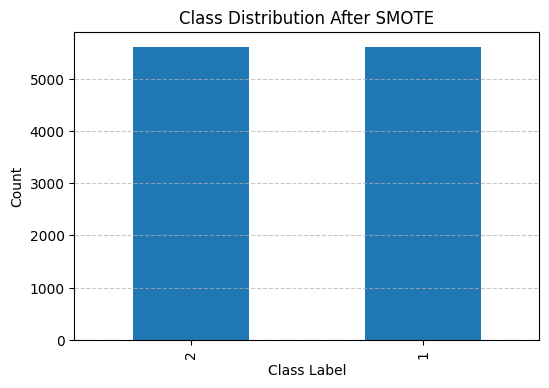

In [2]:
import matplotlib.pyplot as plt
# Visualize class distribution after SMOTE
plt.figure(figsize=(6, 4))
pd.Series(y_resampled).value_counts().plot(kind='bar')
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Class Distribution After SMOTE")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [8]:
import pandas as pd

# Load dataset
exoplanets = pd.read_csv("exoplanets_balanced.csv")  # Use your actual dataset file

# Display dataset shape
print(f"Dataset Shape: {exoplanets.shape}")

# Extract features (excluding the target column)
X = exoplanets.iloc[:, 1:]  # Assuming the first column is the target

# Print the number of features
num_features = X.shape[1]
print(f"Number of Features: {num_features}")


Dataset Shape: (11230, 3198)
Number of Features: 3197


# Training a Convolutional Autoencoder with Keras Tuner

1. Autoencoder Workflow
- Purpose of Autoencoder:

*Feature Extraction:* The encoder part of the autoencoder learns a compressed, latent representation of the input data (features).
Dimensionality Reduction: The latent space (bottleneck layer) represents the data in fewer dimensions while retaining important information.
- Encoder:

It reduces the input data (e.g., 3000 brightness values per time series) into a lower-dimensional latent representation.
The dimensionality of the latent space (e.g., latent_dim = 64, 128, 256) is a hyperparameter that we tune using Keras Tuner.
Decoder:

It reconstructs the original input data from the latent representation to ensure that the encoder captures meaningful patterns.
2. Keras Tuner Workflow
- Purpose:
- Automatically find the best hyperparameters for the autoencoder.
- **Examples of tunable hyperparameters:**
- Latent Space Size (latent_dim): Number of dimensions in the bottleneck layer.
- Number of Layers: How many Conv1D or Dense layers to include in the encoder and decoder.
- Filters and Kernel Sizes: For Conv1D layers, the number of filters and kernel sizes to capture temporal patterns.
- Learning Rate: Optimizer learning rate for training.
3. What Happens During Tuning?
- Keras Tuner runs multiple trials (e.g., 20 trials) with different hyperparameter combinations.
- ***For each trial:***
- The autoencoder is trained on the data.
- The performance is evaluated on the validation set.
- The hyperparameter combination with the best validation performance (val_loss) is selected.
4. Saving the Best Model
- ***After the tuning process:***
- The encoder part of the autoencoder (i.e., the feature extraction portion) is saved.
- The best hyperparameters are saved for future use.

In [4]:
pip install tensorflow

In [6]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Reshape, Input
from tensorflow.keras.models import Model
import keras_tuner as kt

### --- Step 1: Load & Preprocess Data --- ###

# Load dataset
exoplanets = pd.read_csv("exoplanets_balanced.csv")  # Ensure the correct file is used

# Extract features and target
X = exoplanets.iloc[:, 1:]  # Features (3197 columns)
y = exoplanets.iloc[:, 0]   # Target column

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data for Conv1D (timesteps=3197, channels=1)
X_reshaped = X_scaled.reshape(X_scaled.shape[0], 3197, 1)

# Split into training and validation sets (80-20 split)
X_train, X_val = train_test_split(X_reshaped, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

### --- Step 2: Define Autoencoder Model --- ###

def build_conv_autoencoder(hp):
    """Creates a tunable Convolutional Autoencoder model."""
    input_shape = (3197, 1)  # Time steps and 1 channel

    # Encoder
    input_layer = Input(shape=input_shape)
    x = input_layer
    for i in range(hp.Int("num_conv_layers", 1, 3)):  # Tune number of Conv1D layers
        x = Conv1D(
            filters=hp.Choice(f"filters_{i}", [16, 32, 64]),
            kernel_size=hp.Choice(f"kernel_size_{i}", [3, 5, 7]),
            activation="relu",
            padding="same"
        )(x)
    x = Flatten()(x)  # Flatten the encoded features
    latent_dim = hp.Choice("latent_dim", [64, 128, 256])  # Bottleneck size
    latent_layer = Dense(latent_dim, activation="relu")(x)

    # Decoder
    x = Dense(3197, activation="relu")(latent_layer)  # Expand back to feature size
    x = Reshape((3197, 1))(x)  # Reshape for Conv1D
    for i in range(hp.Int("num_conv_layers", 1, 3)):
        x = Conv1D(
            filters=hp.Choice(f"filters_decoder_{i}", [16, 32, 64]),
            kernel_size=hp.Choice(f"kernel_size_decoder_{i}", [3, 5, 7]),
            activation="relu",
            padding="same"
        )(x)
    output_layer = Conv1D(filters=1, kernel_size=1, activation="sigmoid")(x)

    # Compile model
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", [1e-3, 1e-4, 1e-5])
        ),
        loss="mse",
        metrics=["mae"]  # Include MAE for monitoring accuracy
    )

    return autoencoder

### --- Step 3: Tune the Autoencoder Using Keras Tuner --- ###

# Set up the tuner
tuner = kt.RandomSearch(
    build_conv_autoencoder,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=2,
    directory="conv_autoencoder_tuning",
    project_name="exoplanet_autoencoder"
)

# Run the tuning process
tuner.search(
    X_train, X_train,
    epochs=20,
    validation_data=(X_val, X_val),
    batch_size=32
)

# Retrieve best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

print("Best hyperparameters:", best_hps.values)

### --- Step 4: Extract and Save Encoder --- ###

# Extract the encoder part of the best model
encoder = Model(inputs=best_model.input, outputs=best_model.layers[-3].output)  # Adjust index if needed
encoder.save("best_encoder.h5")  # Save the encoder
best_model.save("best_autoencoder.h5")  # Save the full autoencoder

print("Best Encoder saved as 'best_encoder.h5'.")
print("Best Autoencoder saved as 'best_autoencoder.h5'.")
